# Goals for this analysis:
### Core goal: Practice web-scraping
### 1) Understand overall dialogue ditribution across the series by character
### 2) Understand how dialogue distribution evolves across episodes and seasons
### 3) Understand how many times Zuko says "honor" (and if anyone else says it more)

In [1]:
import requests, urllib, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sb, re
from bs4 import BeautifulSoup
import time
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

In [2]:
def add_gaang(dictionary, nest_value = None):
    gaang = ["Aang", "Katara", "Sokka", "Suki", "Toph", "Zuko", "Mai", "Ty Lee", "Azula", "Iroh"]
    if nest_value is not None:
        for character in gaang:
            dictionary[nest_value][character] = []
    else:
        for character in gaang:
            dictionary[character] = []

In [34]:
gaang = ["Aang", "Katara", "Sokka", "Suki", "Toph", "Zuko", "Mai", "Ty Lee", "Azula", "Iroh"]


In [4]:
def clean_descriptors(html_soup, destination):
    for i in html_soup.body.find_all('b'):
        if i.text in gaang or i.text[:-1] in gaang:
            if i.text[-1] == ":" or i.text[-1] == " ":
                key = i.text[:-1]
            else:
                key = i.text


            x = []


            for j in i.next_siblings:
                if j.name == "b":
                    break
                #elif j.name == "i": Removes Italics; issues is emphasized words are italicized
                #    pass
                elif j.string == None:
                    pass
                elif j.name == 'i' and "(" in j.string: #(j.string[0] == "(" or j.string[1] == "("):
                    pass
                elif j.name == 'i' and ")" in j.string:
                    pass
                elif j.name == "i" and ")" in j.next_sibling.string:
                    pass
                elif j.string == "(" or j.string == " (":
                    pass
                else:
                    x.append(str(j)) ## here vs later loop for <i> vs  [] 
            destination[key].append(x)
            pass

## First thing's first: we need to compile our dataset. I found a great repository of ATLA transcripts at atla.avatarpsirit.net and used the beautiful soup library to import the count of lines per episode, using pandas to store and export the results into a dataframe.

In [6]:
atla_ep_data = []
episode_key = "101"
count = 1
gaang = ["Aang", "Katara", "Sokka", "Suki", "Toph", "Zuko", "Mai", "Ty Lee", "Azula", "Iroh"]

while int(episode_key) < 400:
    season = episode_key[0]
    ep = episode_key[1:]
    ep_stats = {"Season": season, "Episode": ep}
    
    url = f"http://atla.avatarspirit.net/transcripts.php?num={episode_key}"
    #print(url)
    page = requests.get(url)
    page_soup = BeautifulSoup(page.content, 'html.parser')

    #if len(page_soup.find_all('title', string = "Error :: AvatarSpirit.net") ) > 0:
    if len(page_soup.find_all("div", {"class": "welcome"}, text = "Error")) > 0:
        episode_key = str(int(episode_key) + 101 - int(episode_key[1:]))
        pass
    else:
        for character in gaang:
            ep_stats[character] = len(page_soup.find_all('b', string = [character, character+":"]))
        atla_ep_data.append(ep_stats)
        episode_key = str(int(episode_key)+1)
        count += 1
            
print (f"Finished parsing all episodes. Total number counted: {count-1} / 61")
del count

Finished parsing all episodes. Total number counted: 61 / 61


In [20]:
df = pd.DataFrame(atla_ep_data)

# Goal 1: Overall Dialogue distribution

## dataset: check
## bargraph: locked and loaded

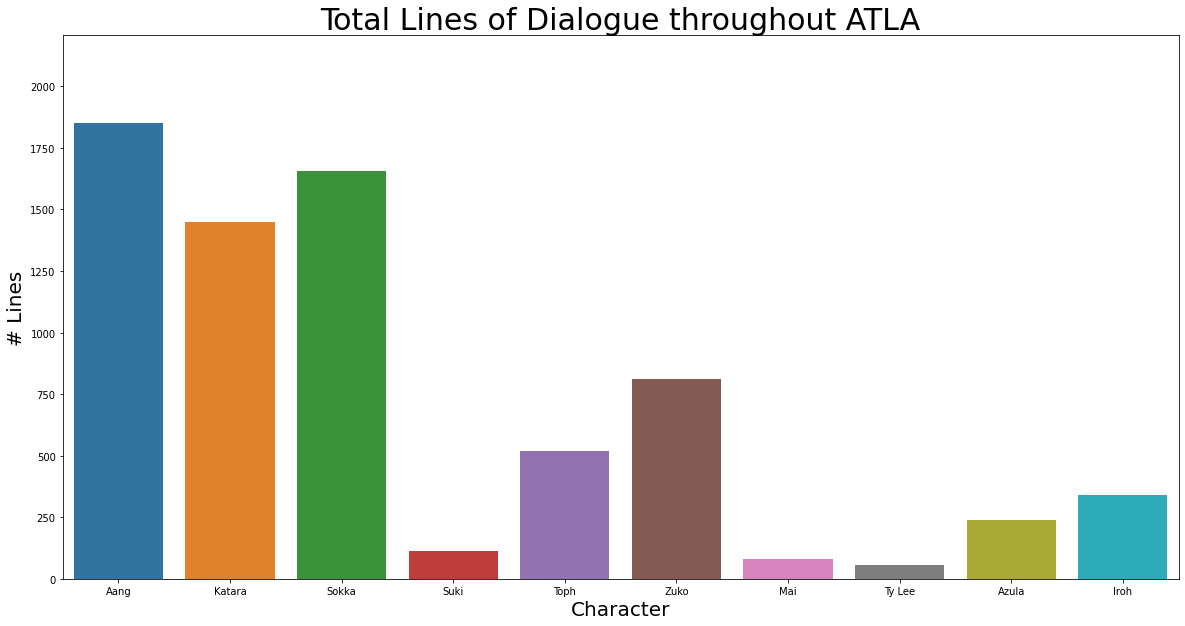

In [10]:
#df[gaang].sum().plot(kind='bar', figsize=(20,10))

plt.figure(figsize=(20,10))
# make barplot and sort bars
total_dialogue = sb.barplot(data = df[gaang], estimator = np.sum, errwidth = 0)
total_dialogue.set_title("Total Lines of Dialogue throughout ATLA", size = 30)
total_dialogue.set_ylabel("# Lines", size = 20)
total_dialogue.set_xlabel("Character", size = 20);

# Goal 2: Dialogue evolution

## We've already got the dataset, but evolution of multiple elements over time is best shown with a multi-line plot. I originally tried to map the results for every character onto a single graph, but that proved...chaotic. I settled on mapping the Core 4 for the public analysis.

## A line plot is a line plot, but matplotlib provides multiple ways to display plots. I wanted all 3 seasons plotted in a single figure, so I used the subplot method. Now to decide if I want a 1x3 or a 3x1 grid...

#### Unfortunately, the horizontal 1,3 matrix isn't very legible given laptop screen size (see below)...

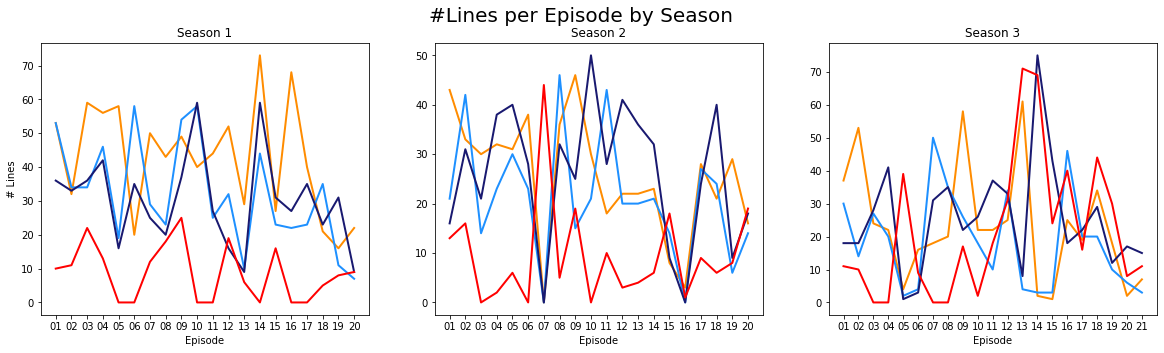

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20,5))
fig.suptitle("#Lines per Episode by Season", fontsize = 20)

seas = 0

for ax in [ax1, ax2, ax3]:
    seas += 1
    for char, col in list(zip("Aang Katara Sokka Zuko".split(" "), "darkorange dodgerblue midnightblue red".split(" "))):
        ax.plot( "Episode", char, data=df[df["Season"]==str(seas)], marker='', color=col, linewidth=2)
        ax.set_title(f"Season {seas}")
        ax.set_xlabel("Episode")

ax1.set_ylabel("# Lines");

#### ...so we'll use a vertical stack instead

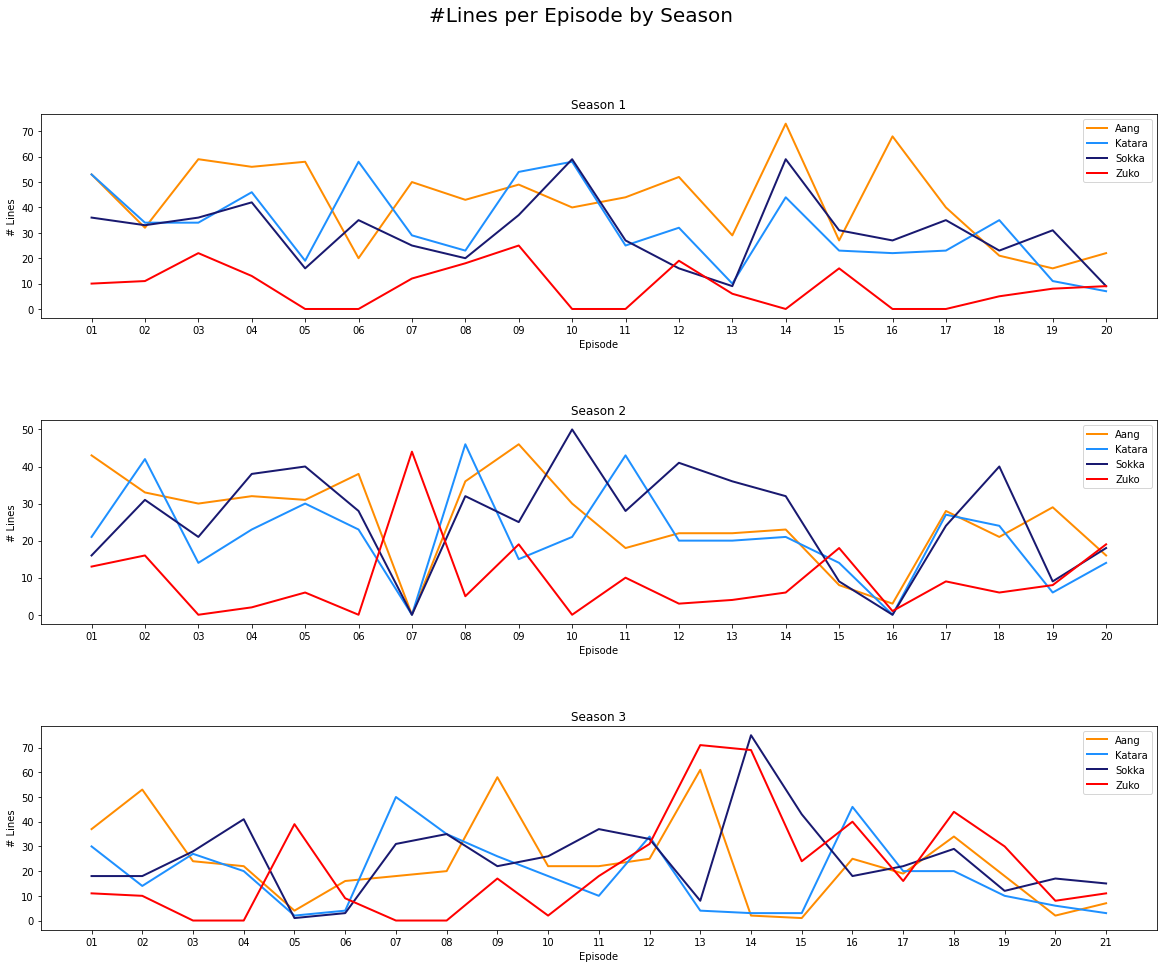

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize = (20,15))
fig.suptitle("#Lines per Episode by Season", fontsize = 20)

seas = 0

for ax in [ax1, ax2, ax3]:
    seas += 1
    for char, col in list(zip("Aang Katara Sokka Zuko".split(" "), "darkorange dodgerblue midnightblue red".split(" "))):
        ax.plot( "Episode", char, data=df[df["Season"]==str(seas)], marker='', color=col, linewidth=2)
        ax.set_title(f"Season {seas}")
        ax.set_xlabel("Episode")
        ax.set_ylabel("# Lines")
        ax.legend()

fig.subplots_adjust(hspace=0.5);

#### It's cool to see how Zuko normalizes with the rest of the Gaang in season 3!

# Goal 3: Honor Guard

## This is tricky, since if you read the documentation for the original dataset, you'll realize I was quite literally only counting the number of lines of dialogue per character (made easy since I noticed the web pages only bolded the character names when designating line speakers). I'll have to find a new way to track the speaker AND capture the dialogue...

In [18]:
def single_string_dialogue(array, name):
    ep_words = []
    for ep in range(len(array[name])):
        ep_words.append(" ".join([items for items in array[name][ep]]))

    all_words_raw = " ".join(ep_words)
    cleaned_words_2 = all_words_raw.replace("<i>", "")
    cleaned_words_2 = cleaned_words_2.replace("</i>", "")
    final_string = re.sub(" +", " ", re.sub(r"[^\w']", ' ', cleaned_words_2.lower()))
    return final_string

In [13]:
atla_ep_data_3 = []
episode_key = "101"
count = 1
gaang = ["Aang", "Katara", "Sokka", "Suki", "Toph", "Zuko", "Mai", "Ty Lee", "Azula", "Iroh"]

while int(episode_key) < 400:
    season = episode_key[0]
    ep = episode_key[1:]
    #ep_stats = {"Season": season, "Episode": ep}
    ep_dialogue = {}
    ep_dict = {"Season": season, "Episode": ep, "Dialogue": {}}
    add_gaang(ep_dict, nest_value = "Dialogue")
    
    url = f"http://atla.avatarspirit.net/transcripts.php?num={episode_key}"
    print(url)
    page = requests.get(url)
    page_soup = BeautifulSoup(page.content, 'html.parser')

    if len(page_soup.find_all("div", {"class": "welcome"}, text = "Error")) > 0:
        episode_key = str(int(episode_key) + 101 - int(episode_key[1:]))
        pass
    else:
        add_gaang(ep_dialogue)        
        clean_descriptors(page_soup, destination = ep_dialogue)       

        for character in gaang:
            for line in ep_dialogue[character]:
                if len(line) > 0:
                    ep_dict["Dialogue"][character].append(" ".join(line).split("\r")[0])
                else:
                    pass
                    
        atla_ep_data_3.append(ep_dict)
        
        episode_key = str(int(episode_key)+1)


http://atla.avatarspirit.net/transcripts.php?num=101
http://atla.avatarspirit.net/transcripts.php?num=102
http://atla.avatarspirit.net/transcripts.php?num=103
http://atla.avatarspirit.net/transcripts.php?num=104
http://atla.avatarspirit.net/transcripts.php?num=105
http://atla.avatarspirit.net/transcripts.php?num=106
http://atla.avatarspirit.net/transcripts.php?num=107
http://atla.avatarspirit.net/transcripts.php?num=108
http://atla.avatarspirit.net/transcripts.php?num=109
http://atla.avatarspirit.net/transcripts.php?num=110
http://atla.avatarspirit.net/transcripts.php?num=111
http://atla.avatarspirit.net/transcripts.php?num=112
http://atla.avatarspirit.net/transcripts.php?num=113
http://atla.avatarspirit.net/transcripts.php?num=114
http://atla.avatarspirit.net/transcripts.php?num=115
http://atla.avatarspirit.net/transcripts.php?num=116
http://atla.avatarspirit.net/transcripts.php?num=117
http://atla.avatarspirit.net/transcripts.php?num=118
http://atla.avatarspirit.net/transcripts.php?n

In [14]:
lines = pd.DataFrame([i["Dialogue"][char] for i in atla_ep_data_3] for char in gaang).T
lines.columns = gaang
#lines.to_pickle("ATLA Dialogue.pkl")

In [ ]:
#lines = pd.read_pickle("ATLA Dialogue.pkl")

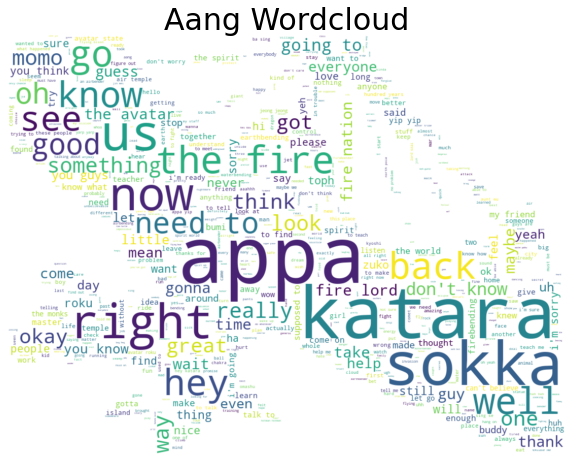

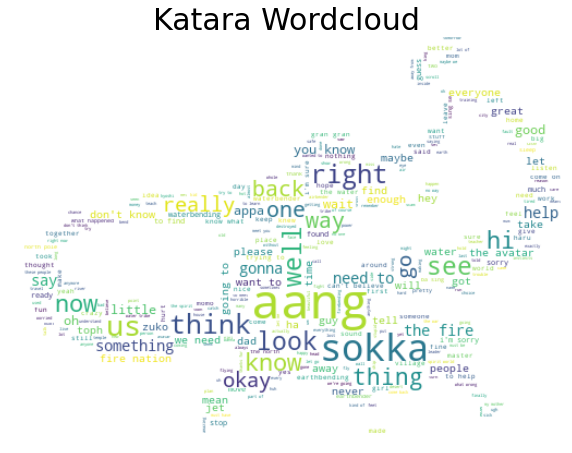

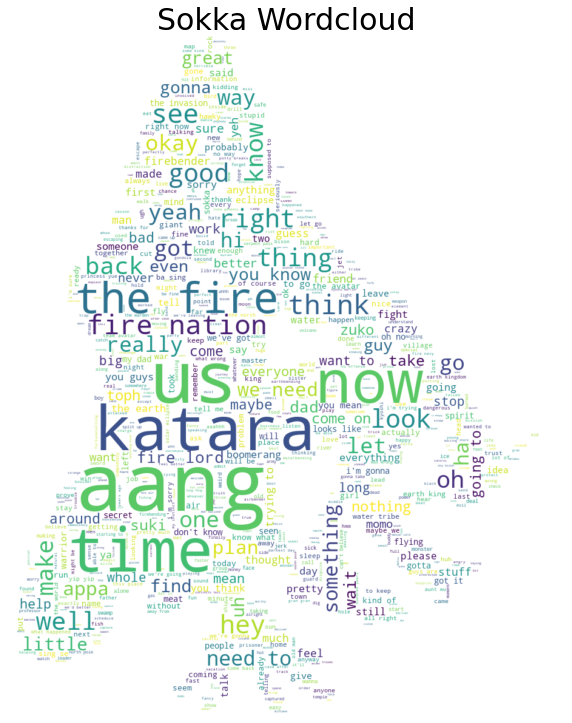

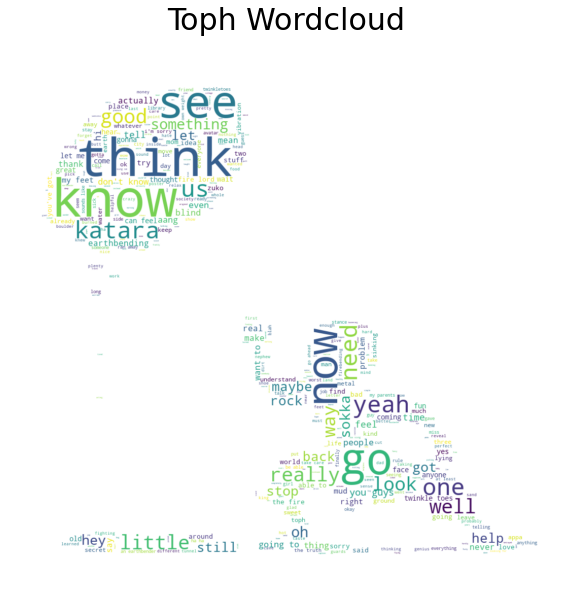

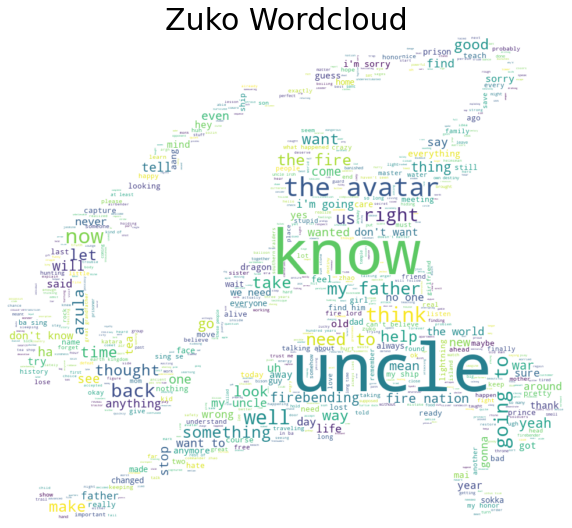

In [15]:
gaang = ["Aang", "Katara", "Sokka", "Toph", "Zuko"]#, "Suki", "Mai", "Ty Lee", "Azula", "Iroh"]
gaang_images = ["Aang Photoshop.jpg", "Katara Photoshop.jpg", "Sokka Photoshop.jpg", "Toph Photoshop.jpg",
               "Zuko Photoshop.jpg"]

for character, av_image in zip(gaang, gaang_images):    
    char_string = single_string_dialogue(lines, character) 
    """
    Create the word cloud using the word cloud library
    """
    stopwords = set(STOPWORDS)
    char_mask = np.array(Image.open(av_image))
    wc = WordCloud(stopwords=stopwords, mask = char_mask, background_color="white", mode="RGBA", max_words=750).generate(char_string.lower())
    plt.figure(figsize=(10,15))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f"{character} Wordcloud", size = 30)
    plt.axis("off")
    plt.show()
    #wc.to_file(f"{character} wordcloud.png")

### I genuinely don't see honor anywhere...but I do see tea (left to the left of know and about halfway down on the arm). Looks like we'll need to figure something else out. 


### Enjoy the alternate picture of Aang below

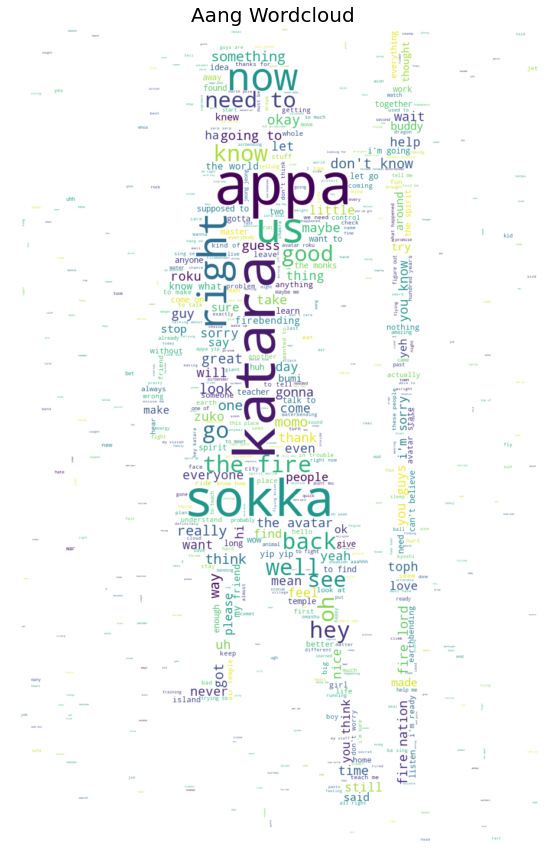

In [19]:
aang_string = single_string_dialogue(lines, "Aang")

stopwords = set(STOPWORDS)
aang_mask = np.array(Image.open("Aang image.jpg"))
wc = WordCloud(stopwords=stopwords, mask = aang_mask, background_color="white", mode="RGBA", max_words=750).generate(aang_string.lower())
plt.figure(figsize=(10,15))
plt.imshow(wc, interpolation='bilinear')
plt.title("Aang Wordcloud", size = 20)
plt.axis("off")
plt.show()
#wc.to_file("Aang wordcloud.png")

In [72]:
for character in gaang:
    hon_count = single_string_dialogue(lines, character).count("honor")
    hon_percent = hon_count / single_string_dialogue(lines, character).count(" ")*100 
    #round(hon_count / single_string_dialogue(lines, character).count(" ")*100, 2)
    print(f"{character} says honor {hon_count} times, or {hon_percent:.2f}% of the time")

#zuko_lines = single_string_dialogue(lines, "Zuko")

Aang says honor 4 times, or 0.02% of the time
Katara says honor 4 times, or 0.03% of the time
Sokka says honor 3 times, or 0.02% of the time
Suki says honor 1 times, or 0.10% of the time
Toph says honor 0 times, or 0.00% of the time
Zuko says honor 12 times, or 0.14% of the time
Mai says honor 0 times, or 0.00% of the time
Ty Lee says honor 0 times, or 0.00% of the time
Azula says honor 6 times, or 0.18% of the time
Iroh says honor 6 times, or 0.12% of the time
